# Zeel Patel

In [1]:
spark.version

'3.1.3'

## Cleaning Data 

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, desc, month, year, length, corr
from pyspark.sql.types import IntegerType


In [5]:
spark = SparkSession.builder \
    .appName("Amazon Reviews Analysis") \
    .getOrCreate()

data_path = "gs://msca-bdp-amazon/amazon_reviews/"
df = spark.read.option("header", "true").option("delimiter", "\t").csv(data_path)

### Removing null values from Star Rating Column

In [ ]:
# Filtering out null values early in the pipeline to reduce the data size being processed in subsequent steps
# This minimizes memory usage and shuffling during transformations.

In [7]:
df_cleaned_rating = df.filter(df.star_rating.isNotNull())

print("Total rows after removing nulls in star_rating:", df_cleaned_rating.count())


Total rows after removing nulls in star_rating: 150960015


In [ ]:
product_category_counts = df_cleaned_rating.groupBy("product_category").count().orderBy(desc("count"))
product_category_counts.show(truncate=False)

# Count the total number of unique product categories
num_categories = df_cleaned_rating.select("product_category").distinct().count()
print(f"Number of unique product categories: {num_categories}")


+----------------------+--------+
|product_category      |count   |
+----------------------+--------+
|Books                 |19531194|
|Digital_Ebook_Purchase|17622381|
|Wireless              |9001881 |
|PC                    |6908551 |
|Home                  |6221537 |
|Apparel               |5906322 |
|Health & Personal Care|5331215 |
|Beauty                |5115452 |
|Video DVD             |5069136 |
|Mobile_Apps           |5033376 |
|Kitchen               |4880460 |
|Toys                  |4864243 |
|Sports                |4849563 |
|Music                 |4751540 |
|Shoes                 |4366916 |
|Digital_Video_Download|4057147 |
|Automotive            |3514709 |
|Electronics           |3093861 |
|Pet Products          |2643614 |
|Office Products       |2642403 |
+----------------------+--------+
only showing top 20 rows



Number of unique product categories: 56


### Cleaning Product Categories

In [ ]:
# Selecting only the necessary column ("product_category") to reduce the amount of data processed
# Using .distinct() to remove duplicate categories, which is efficient for high-cardinality data in Spark

In [ ]:
unique_categories = df_cleaned_rating.select("product_category").distinct().orderBy("product_category")

unique_categories.show(56, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_category                                                                                                                                                                                                                                                      

In [15]:
from pyspark.sql.functions import length

# Filter out rows where the length of product_category is greater than 30
df_cleaned_categories = df_cleaned_rating.filter(length("product_category") <= 30)

# Show distinct categories to verify that long categories have been removed
df_cleaned_categories.select("product_category").distinct().orderBy("product_category").show(56, truncate=False)


+------------------------+
|product_category        |
+------------------------+
|Apparel                 |
|Automotive              |
|Baby                    |
|Beauty                  |
|Books                   |
|Camera                  |
|Digital_Ebook_Purchase  |
|Digital_Music_Purchase  |
|Digital_Software        |
|Digital_Video_Download  |
|Digital_Video_Games     |
|Electronics             |
|Furniture               |
|Gift Card               |
|Grocery                 |
|Health & Personal Care  |
|Home                    |
|Home Entertainment      |
|Home Improvement        |
|Jewelry                 |
|Kitchen                 |
|Lawn and Garden         |
|Luggage                 |
|Major Appliances        |
|Mobile_Apps             |
|Mobile_Electronics      |
|Music                   |
|Musical Instruments     |
|Office Products         |
|Outdoors                |
|PC                      |
|Personal_Care_Appliances|
|Pet Products            |
|Shoes                   |
|

In [ ]:
# Using show() with truncate=False to display all categories fully without cutting off long names
# This is only for inspection purposes and doesn’t affect the data processing pipeline.

In [ ]:
# Using Spark's built-in length() function, which is optimized for distributed operations
# Filtering out long product categories early reduces the data size for downstream steps, minimizing memory and CPU usage.

### Total Product Categories

In [16]:
# Count the total number of unique product categories
num_categories_filtered = df_cleaned_categories.select("product_category").distinct().count()
print(f"Number of unique product categories: {num_categories_filtered}")

Number of unique product categories: 43


In [ ]:
# This is done independently to avoid combining multiple filters, allowing each step to be optimized separately.
# Filtering out rows where customer_id is null reduces the size of the DataFrame, making it more memory-efficient for subsequent operations.

In [18]:
from pyspark.sql.functions import col

# Filter out rows where customer_id is null
df_cleaned = df_cleaned_categories.filter(col("customer_id").isNotNull())

# Verify the results
df_cleaned.show(10)
print("Total rows after removing null customer_id:", df_cleaned.count())


+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   22873041|R3ARRMDEGED8RD|B00KJWQIIC|     335625766|Plemo 14-Inch Lap...|              PC|          5|            0|          0|   N|                Y|Pleasantly surprised|I was very surpri...| 2015-08-31|
|         US|   30088427| RQ28TSA020Y6J|B013ALA9LA|     671157305|TP-Link OnHub AC1...|              PC|          5|    

Total rows after removing null customer_id: 150960002


### Final Dataframe to be worked with

In [19]:
df_cleaned.describe().show()

+-------+-----------+-------------------+--------------+--------------------+--------------------+--------------------+----------------+------------------+------------------+------------------+---------+-----------------+--------------------+--------------------+-----------+
|summary|marketplace|        customer_id|     review_id|          product_id|      product_parent|       product_title|product_category|       star_rating|     helpful_votes|       total_votes|     vine|verified_purchase|     review_headline|         review_body|review_date|
+-------+-----------+-------------------+--------------+--------------------+--------------------+--------------------+----------------+------------------+------------------+------------------+---------+-----------------+--------------------+--------------------+-----------+
|  count|  150960002|          150960002|     150960002|           150960002|           150960002|           150960002|       150960002|         150960002|         15096000

In [ ]:
# Avoiding caching of large DataFrames (like df_cleaned) prevents memory overload and optimizes resource usage in a distributed environment.
# Caching is reserved only for smaller, frequently reused subsets, if needed, rather than full datasets.

# 1. Product Category with Most Reviews

In [ ]:
# This approach is computationally effective as it groups and counts in a distributed manner, then retrieves only the top result without sorting the entire dataset.

In [21]:
category_reviews = df_cleaned.groupBy("product_category").count().orderBy(desc("count")).limit(1)
category_reviews.show()

+----------------+--------+
|product_category|   count|
+----------------+--------+
|           Books|19531194|
+----------------+--------+



# 2. Product Category with Highest / Lowest Review Star Ratings

In [ ]:
# This approach is efficient because it minimizes data processing by reducing, aggregating, and only retrieving the necessary top results.

In [22]:
from pyspark.sql.functions import avg, desc

category_ratings = df_cleaned.groupBy("product_category").agg(avg("star_rating").alias("avg_rating"))

print("The product with the Highest Star Rating is: ")
highest_rated_category = category_ratings.orderBy(desc("avg_rating")).show(1)

print("The product with the Lowest Star Rating is: ")
lowest_rated_category = category_ratings.orderBy("avg_rating").show(1)


The product with the Highest Star Rating is: 


+----------------+-----------------+
|product_category|       avg_rating|
+----------------+-----------------+
|       Gift Card|4.731363105858364|
+----------------+-----------------+
only showing top 1 row

The product with the Lowest Star Rating is: 


+----------------+------------------+
|product_category|        avg_rating|
+----------------+------------------+
|Digital_Software|3.5393303553935973|
+----------------+------------------+
only showing top 1 row



# 3. Seasonality in Reviews

In [23]:
df_with_date = df_cleaned.withColumn("year", year("review_date")).withColumn("month", month("review_date"))
yearly_reviews = df_with_date.groupBy("year", "month").count().orderBy("year", "month")

yearly_reviews.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|null| null|11599|
|1995|    6|    2|
|1995|    7|   23|
|1995|    8|   19|
|1995|    9|   27|
|1995|   10|   45|
|1995|   11|   46|
|1995|   12|   39|
|1996|    1|   69|
|1996|    2|   31|
|1996|    5|  348|
|1996|    6|  436|
|1996|    7|  417|
|1996|    8|  471|
|1996|    9|  587|
|1996|   10|  541|
|1996|   11|  661|
|1996|   12| 1128|
|1997|    1| 1574|
|1997|    2| 1518|
+----+-----+-----+
only showing top 20 rows



### Cleaning review data

In [24]:
from pyspark.sql.functions import col, year, month

df_cleaned_date = df_cleaned.filter(col("review_date").isNotNull())

df_cleaned_date = df_cleaned_date.withColumn("year", year("review_date")).withColumn("month", month("review_date"))

df_cleaned_date = df_cleaned_date.filter(col("year").isNotNull() & col("month").isNotNull())

df_cleaned_date.select("review_date", "year", "month").show(10)


+-----------+----+-----+
|review_date|year|month|
+-----------+----+-----+
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
+-----------+----+-----+
only showing top 10 rows



In [25]:
df_with_date = df_cleaned_date.withColumn("year", year("review_date")).withColumn("month", month("review_date"))
yearly_reviews = df_with_date.groupBy("year", "month").count().orderBy("year", "month")

yearly_reviews.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|1995|    6|    2|
|1995|    7|   23|
|1995|    8|   19|
|1995|    9|   27|
|1995|   10|   45|
|1995|   11|   46|
|1995|   12|   39|
|1996|    1|   69|
|1996|    2|   31|
|1996|    5|  348|
|1996|    6|  436|
|1996|    7|  417|
|1996|    8|  471|
|1996|    9|  587|
|1996|   10|  541|
|1996|   11|  661|
|1996|   12| 1128|
|1997|    1| 1574|
|1997|    2| 1518|
|1997|    3| 2063|
+----+-----+-----+
only showing top 20 rows



24/11/07 20:15:41 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 212 for reason Container marked as failed: container_1731005608153_0001_01_000213 on host: hub-msca-bdp-dphub-students-zeel-sw-w5rh.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
24/11/07 20:15:41 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 212 on hub-msca-bdp-dphub-students-zeel-sw-w5rh.c.msca-bdp-students.internal: Container marked as failed: container_1731005608153_0001_01_000213 on host: hub-msca-bdp-dphub-students-zeel-sw-w5rh.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
24/11/07 20:15:41 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 214 for reason Container marked as failed: container_1731005608153_0001_01_000215 on host: hub-msca-bdp-dphub

In [ ]:
# Filtering out null dates and extracting year and month early reduces the dataset size, ensuring only relevant data is processed in subsequent steps, 
# which saves memory and computational resources.

In [27]:
from pyspark.sql.functions import year, min, max

# Finding the range of years in the dataset
year_range = df_cleaned_date.select(year("review_date").alias("year")).agg(min("year").alias("min_year"), max("year").alias("max_year"))
year_range.show()


+--------+--------+
|min_year|max_year|
+--------+--------+
|    1995|    2015|
+--------+--------+



### Creating buckets for year range (1900s, 2000s, 2010s)

In [28]:
from pyspark.sql.functions import when

#Making buckets for the years

# Creating a "decade" column based on the extracted year
df_with_decade = df_cleaned_date.withColumn("year", year("review_date"))

df_with_decade = df_with_decade.withColumn(
    "decade",
    when((df_with_decade["year"] >= 1995) & (df_with_decade["year"] < 2000), "1990s")
    .when((df_with_decade["year"] >= 2000) & (df_with_decade["year"] < 2010), "2000s")
    .when((df_with_decade["year"] >= 2010) & (df_with_decade["year"] < 2020), "2010s")
)

# Verify the assignment of decades
df_with_decade.select("year", "decade").distinct().orderBy("year").show()


+----+------+
|year|decade|
+----+------+
|1995| 1990s|
|1996| 1990s|
|1997| 1990s|
|1998| 1990s|
|1999| 1990s|
|2000| 2000s|
|2001| 2000s|
|2002| 2000s|
|2003| 2000s|
|2004| 2000s|
|2005| 2000s|
|2006| 2000s|
|2007| 2000s|
|2008| 2000s|
|2009| 2000s|
|2010| 2010s|
|2011| 2010s|
|2012| 2010s|
|2013| 2010s|
|2014| 2010s|
+----+------+
only showing top 20 rows



In [29]:
from pyspark.sql.functions import month

# Extracting month from review_date
df_with_decade_month = df_with_decade.withColumn("month", month("review_date"))

monthly_reviews_by_decade = df_with_decade_month.groupBy("decade", "month", "star_rating").count().orderBy("decade", "month")
monthly_reviews_by_decade.show(24)


+------+-----+-----------+-----+
|decade|month|star_rating|count|
+------+-----+-----------+-----+
| 1990s|    1|          1| 2016|
| 1990s|    1|          5|22690|
| 1990s|    1|          4| 5851|
| 1990s|    1|          3| 2173|
| 1990s|    1|          2| 1459|
| 1990s|    2|          2| 1553|
| 1990s|    2|          5|21956|
| 1990s|    2|          1| 2145|
| 1990s|    2|          3| 2056|
| 1990s|    2|          4| 5222|
| 1990s|    3|          3| 2395|
| 1990s|    3|          1| 2315|
| 1990s|    3|          4| 6241|
| 1990s|    3|          2| 1658|
| 1990s|    3|          5|26124|
| 1990s|    4|          4| 6646|
| 1990s|    4|          5|28174|
| 1990s|    4|          1| 2471|
| 1990s|    4|          2| 1931|
| 1990s|    4|          3| 2515|
| 1990s|    5|          4| 6599|
| 1990s|    5|          2| 1847|
| 1990s|    5|          1| 2326|
| 1990s|    5|          3| 2575|
+------+-----+-----------+-----+
only showing top 24 rows



#### Plotting graph for 1900s

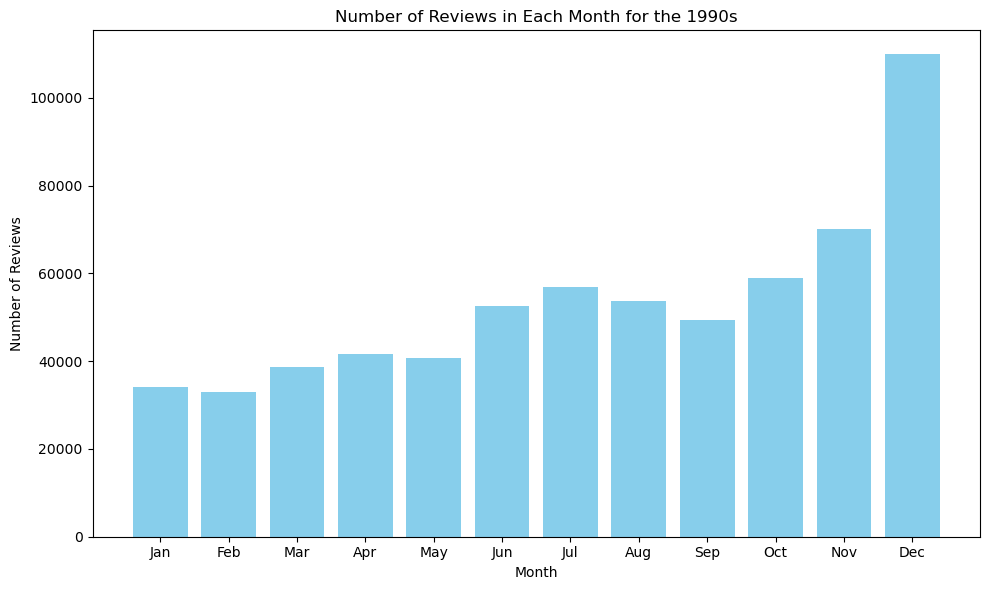

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

reviews_1990s = monthly_reviews_by_decade.filter(monthly_reviews_by_decade.decade == "1990s") \
                                         .groupBy("month") \
                                         .sum("count") \
                                         .orderBy("month")

reviews_1990s_pd = reviews_1990s.toPandas()

reviews_1990s_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.bar(reviews_1990s_pd["month"], reviews_1990s_pd["review_count"], color='skyblue')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews in Each Month for the 1990s")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.tight_layout()
plt.show()


#### Plotting graph for 2000s

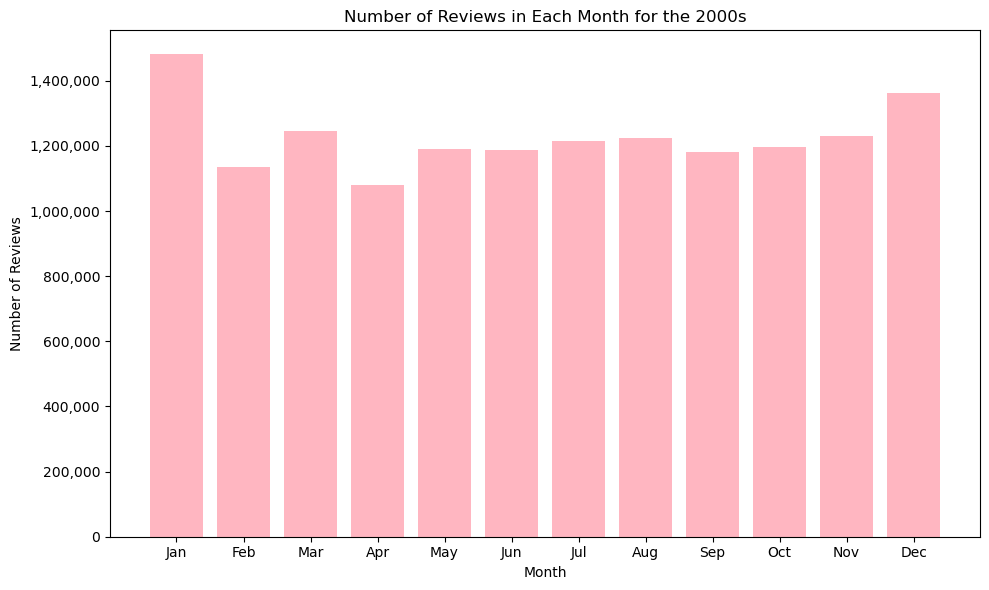

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

reviews_2000s = monthly_reviews_by_decade.filter(monthly_reviews_by_decade.decade == "2000s") \
                                         .groupBy("month") \
                                         .sum("count") \
                                         .orderBy("month")

reviews_2000s_pd = reviews_2000s.toPandas()

reviews_2000s_pd.columns = ["month", "review_count"]

import matplotlib.ticker as mticker

plt.figure(figsize=(10, 6))
plt.bar(reviews_2000s_pd["month"], reviews_2000s_pd["review_count"], color='lightpink')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews in Each Month for the 2000s")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()



#### Plotting graph for 2010s

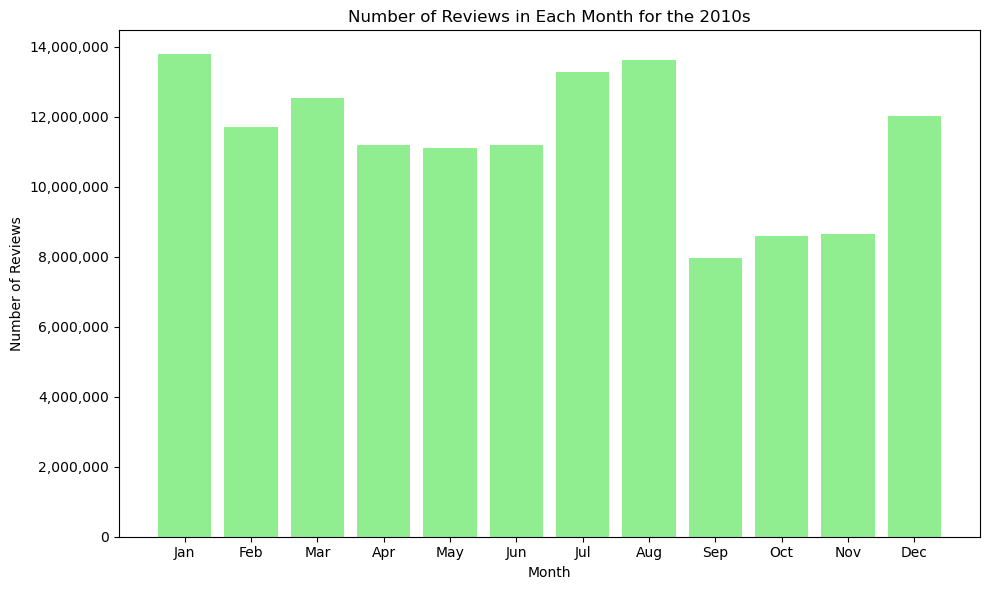

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

reviews_2010s = monthly_reviews_by_decade.filter(monthly_reviews_by_decade.decade == "2010s") \
                                         .groupBy("month") \
                                         .sum("count") \
                                         .orderBy("month")

reviews_2010s_pd = reviews_2010s.toPandas()

reviews_2010s_pd.columns = ["month", "review_count"]


plt.figure(figsize=(10, 6))
plt.bar(reviews_2010s_pd["month"], reviews_2010s_pd["review_count"], color='lightgreen')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews in Each Month for the 2010s")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

Findings on Seasonality
1990s: The bar graph for the 1990s shows a steady increase in review counts throughout the year, with a noticeable peak in December. This suggests that reviews tend to increase towards the end of the year, potentially due to holiday shopping periods or end-of-year purchases.

2000s: In the 2000s, we observe a similar pattern but on a much larger scale. January shows a significant peak, followed by a stable review count throughout the rest of the year, with a slight increase again in December. This could indicate that post-holiday reviews are prominent in January, followed by consistent monthly reviews.

2010s: The 2010s decade shows a substantial increase in review volume across all months, reflecting the rise in e-commerce activity. The peak is again in January, with a steady flow of reviews throughout the year. Unlike the previous decades, we see a drop in September, possibly due to a temporary slowdown in shopping activity during this month.

# 3.1 Consistency of Reviews by Product Category

#### Seasonality consistency of reviews for Books in 2014

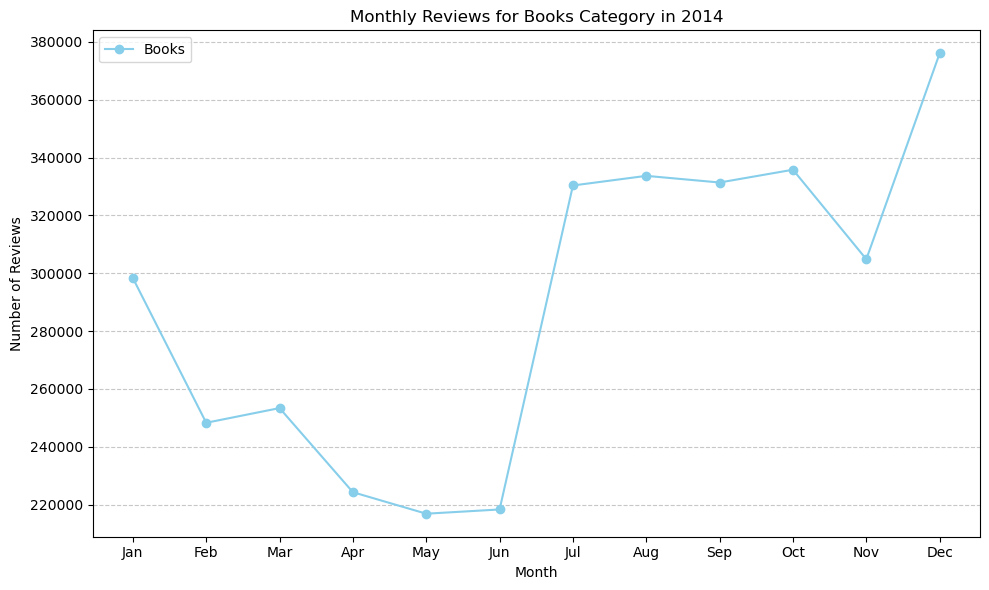

In [45]:
df_books_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Books"))

monthly_reviews_books_2014 = df_books_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_books_2014_pd = monthly_reviews_books_2014.toPandas()
monthly_reviews_books_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_books_2014_pd["month"], monthly_reviews_books_2014_pd["review_count"], marker='o', color='skyblue', label='Books')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Books Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#### Seasonality consistency of reviews forElectronics in 2014

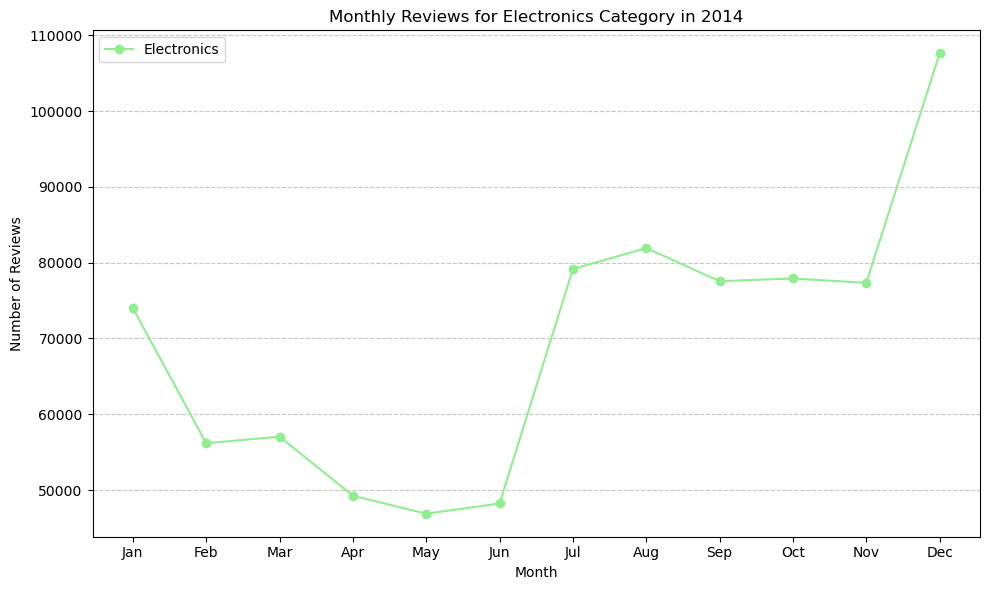

In [46]:
df_electronics_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Electronics"))

monthly_reviews_electronics_2014 = df_electronics_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_electronics_2014_pd = monthly_reviews_electronics_2014.toPandas()
monthly_reviews_electronics_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_electronics_2014_pd["month"], monthly_reviews_electronics_2014_pd["review_count"], marker='o', color='lightgreen', label='Electronics')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Electronics Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#### Seasonality consistency of reviews for Shoes in 2014

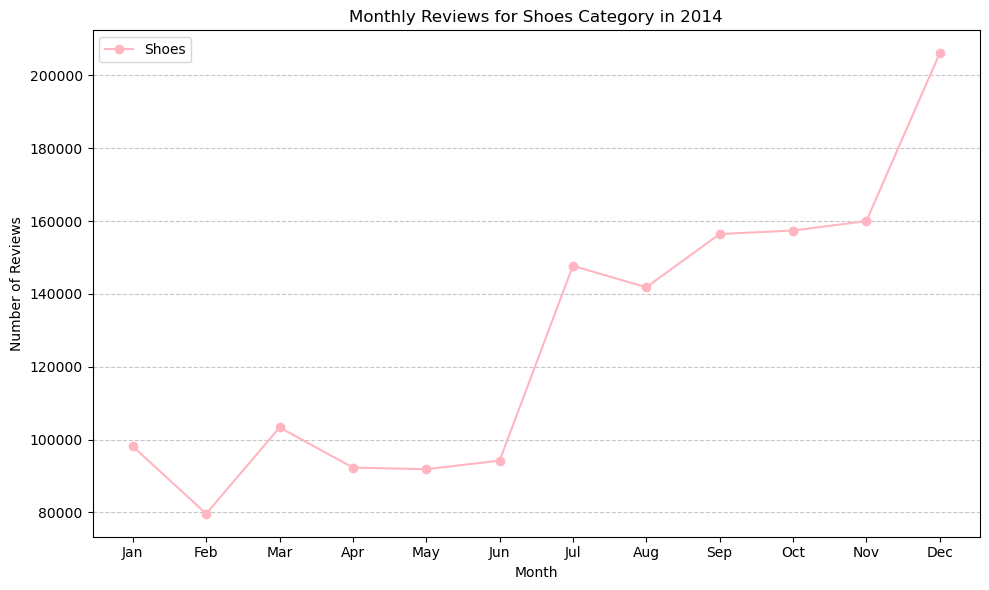

In [ ]:
from pyspark.sql.functions import month, year
import matplotlib.pyplot as plt

df_shoes_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Shoes"))

monthly_reviews_shoes_2014 = df_shoes_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_shoes_2014_pd = monthly_reviews_shoes_2014.toPandas()
monthly_reviews_shoes_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_shoes_2014_pd["month"], monthly_reviews_shoes_2014_pd["review_count"], marker='o', color='lightpink', label='Shoes')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Shoes Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#### Seasonality consistency of reviews for Toys in 2014

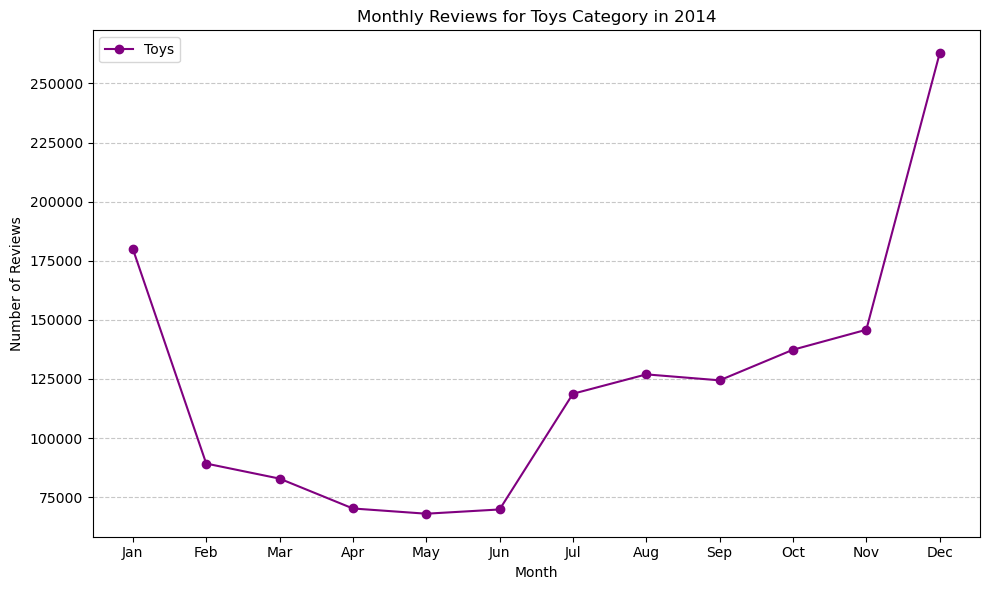

In [ ]:
from pyspark.sql.functions import month, year
import matplotlib.pyplot as plt

df_toys_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Toys"))

monthly_reviews_toys_2014 = df_toys_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_toys_2014_pd = monthly_reviews_toys_2014.toPandas()
monthly_reviews_toys_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_toys_2014_pd["month"], monthly_reviews_toys_2014_pd["review_count"], marker='o', color='purple', label='Toys')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Toys Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In this analysis, we examined the monthly review trends for four different product categories—Electronics, Books, Shoes, and Toys—in the year 2014. Our goal was to determine if each category received a consistent number of reviews throughout the year and to identify any seasonal spikes in review counts.

Findings
Electronics:

The Electronics category showed relatively low review counts during the middle of the year, particularly from April to June.
However, there was a significant spike in December, indicating an increase in reviews towards the end of the year, likely influenced by holiday shopping and end-of-year purchases.
Conclusion: Reviews for Electronics are not consistent throughout the year, with a clear seasonal increase in December.
Books:

The Books category followed a similar pattern to Electronics, with lower review counts in the middle of the year (April to June).
There was a notable increase in reviews from July onwards, with a peak in December.
Conclusion: Reviews for Books show seasonal variation, with a consistent upward trend toward the end of the year, possibly due to holiday gift purchases.
Shoes:

Reviews for the Shoes category remained relatively stable from January to October, with a modest increase starting in July.
The most significant spike occurred in December, indicating a high volume of reviews during the holiday season.
Conclusion: Shoes reviews are somewhat consistent through most of the year, but they experience a sharp increase in December, likely due to seasonal purchases.
Toys:

The Toys category exhibited the most pronounced seasonal trend, with a clear drop in reviews from February through June.
Review counts gradually increased from July onwards, with a dramatic peak in December.
Conclusion: Toys are highly seasonal, with a significant increase in reviews in December, aligning with holiday gifting trends.

# 3.2 Are product categories getting more reviews during certain times of the year?

Consistency of Reviews: None of the product categories analyzed received a consistent number of reviews throughout the year. Each category experienced fluctuations, particularly around the holiday season.

Seasonal Trends:
Electronics, Books, Shoes, and Toys all saw a significant increase in December, likely due to holiday shopping.
Toys had the most pronounced seasonality, with a marked increase in December, likely reflecting its popularity as a holiday gift category.



# 4. Which reviews are getting the most helpful votes/ total votes?

In [ ]:
from pyspark.sql.functions import desc, col, substring


df_helpful_reviews = df_cleaned_date.filter(df_cleaned_date["helpful_votes"].isNotNull())


# Shortening the length of the "review_body" to 60 characters for easy readability
top_helpful_reviews = df_helpful_reviews \
    .orderBy(desc("helpful_votes")) \
    .select(
        "review_id", 
        "product_category", 
        "helpful_votes", 
        "total_votes", 
        substring(col("review_body"), 1, 60).alias("review_body_truncated") 
    ) \
    .limit(5)

top_helpful_reviews.show(truncate=False)



+--------------+----------------+-------------+-----------+------------------------------------------------------------+
|review_id     |product_category|helpful_votes|total_votes|review_body_truncated                                       |
+--------------+----------------+-------------+-----------+------------------------------------------------------------+
|R3TL1C8CERBRGI|Books           |9992         |10252      |As the father of two teenagers, I found this book invaluable|
|RIWNO96MF2QVV |PC              |9991         |10291      |[[VIDEOID:mo1JKIM8H2U3LT6]]I have loved and used my Kindle K|
|R1UJFMADX2W7HQ|Camera          |999          |1023       |If you're looking for a pocketable camera that has reasonabl|
|R3NYVQL5KSDW84|Books           |999          |1155       |Just to set the record straight on Casual Vacancy, I was giv|
|R2CODY83YSS59M|Beauty          |999          |1048       |After many years of manual brushing, I took the chance on on|
+--------------+----------------

# 4.1 Any correlation between the length of review headline/ review body and the "helpfulness" of the review?

Dividing the length of reviews by the number of characters present in the "review_body" column. 
These are then arranged into 4 buckets: 0-50, 51-100, 101-200, 201-500, 500+

In [ ]:
from pyspark.sql.functions import length, col, when, sum as spark_sum
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

df_with_length = df_cleaned_date.withColumn("review_length", length("review_body"))

df_buckets = df_with_length.withColumn(
    "length_bucket",
    when(col("review_length") <= 50, "0-50")
    .when((col("review_length") > 50) & (col("review_length") <= 100), "51-100")
    .when((col("review_length") > 100) & (col("review_length") <= 200), "101-200")
    .when((col("review_length") > 200) & (col("review_length") <= 500), "201-500")
    .when((col("review_length") > 500), "500+")
)

bucket_summary = df_buckets.filter(col("length_bucket").isNotNull()) \
    .groupBy("length_bucket") \
    .agg(
        spark_sum("total_votes").alias("total_votes_sum"),
        spark_sum("helpful_votes").alias("helpful_votes_sum")
    )

order = ["0-50", "51-100", "101-200", "201-500", "500+"]
bucket_summary = bucket_summary.orderBy(col("length_bucket").isin(order).desc(), col("length_bucket"))

bucket_summary_pd = bucket_summary.toPandas()
bucket_summary_pd["length_bucket"] = pd.Categorical(bucket_summary_pd["length_bucket"], categories=order, ordered=True)
bucket_summary_pd = bucket_summary_pd.sort_values("length_bucket")



In [60]:
bucket_summary.show()

+-------------+---------------+-----------------+
|length_bucket|total_votes_sum|helpful_votes_sum|
+-------------+---------------+-----------------+
|         0-50|      9774236.0|        4169587.0|
|      101-200|    5.6467545E7|      3.7278546E7|
|      201-500|    9.7696176E7|      7.1028503E7|
|         500+|   2.07081663E8|     1.68170702E8|
|       51-100|    1.2018031E7|        6932867.0|
+-------------+---------------+-----------------+



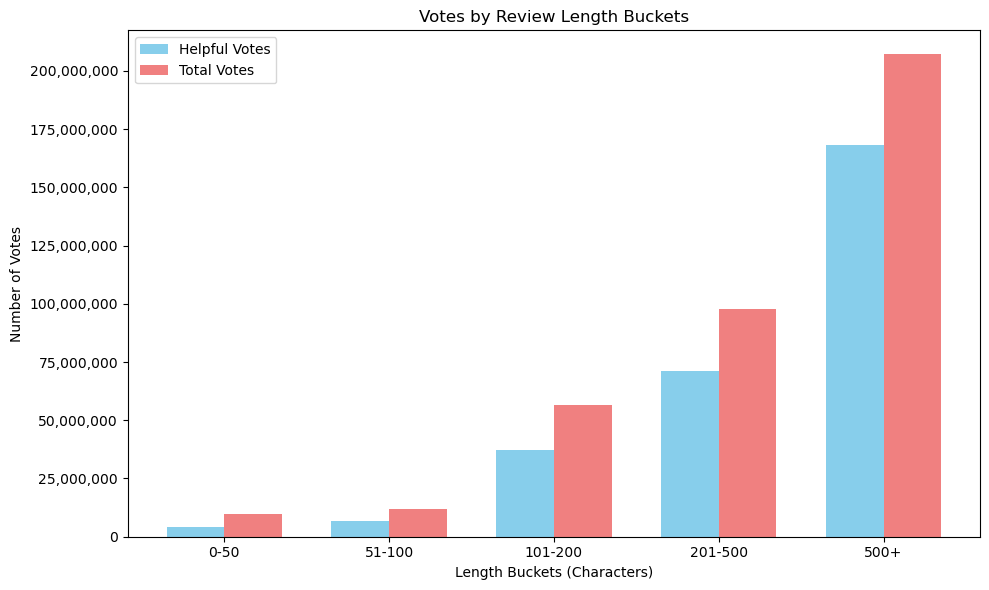

In [ ]:
plt.figure(figsize=(10, 6))

bar_width = 0.35
r1 = range(len(bucket_summary_pd["length_bucket"]))
r2 = [x + bar_width for x in r1]

plt.bar(r1, bucket_summary_pd["helpful_votes_sum"], color='skyblue', width=bar_width, label="Helpful Votes")
plt.bar(r2, bucket_summary_pd["total_votes_sum"], color='lightcoral', width=bar_width, label="Total Votes")

plt.xlabel("Length Buckets (Characters)")
plt.ylabel("Number of Votes")
plt.title("Votes by Review Length Buckets")
plt.xticks([r + bar_width/2 for r in range(len(bucket_summary_pd["length_bucket"]))], bucket_summary_pd["length_bucket"])
plt.legend()

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

This analysis indicates that review length positively correlates with both helpful votes and total votes, with longer reviews generally receiving more engagement. The results suggest that users seeking helpful feedback are more likely to find value in detailed reviews. 

Review Length and Votes:

As the review length increases, both the total votes and helpful votes tend to increase. This pattern suggests that longer reviews generally receive more engagement from readers, which could be because they provide more detailed insights.
The bucket 500+ characters received the highest number of both total and helpful votes, indicating that very detailed reviews are highly valued by readers.

# 4.2 Correlation between how many reviews a certain customer published and the "helpfulness" of the reviews

In [ ]:
from pyspark.sql.functions import count, sum as spark_sum

customer_review_summary = df_cleaned_date.groupBy("customer_id").agg(
    count("review_id").alias("total_reviews"),
    spark_sum("total_votes").alias("total_votes_sum"),
    spark_sum("helpful_votes").alias("helpful_votes_sum")
)

customer_review_summary.orderBy("total_reviews", ascending=False).show(truncate=False)


+-----------+-------------+---------------+-----------------+
|customer_id|total_reviews|total_votes_sum|helpful_votes_sum|
+-----------+-------------+---------------+-----------------+
|50122160   |59623        |311666.0       |259768.0         |
|50732546   |30760        |162173.0       |121865.0         |
|52496677   |14367        |106469.0       |93574.0          |
|52004451   |10905        |19117.0        |17605.0          |
|50736950   |10129        |42561.0        |20222.0          |
|18116317   |8723         |30145.0        |27819.0          |
|44731853   |7585         |19084.0        |16572.0          |
|50881246   |7401         |99448.0        |87340.0          |
|38002140   |7197         |17529.0        |9446.0           |
|36642996   |6988         |54383.0        |46232.0          |
|43430756   |6610         |25630.0        |23046.0          |
|50068216   |6540         |37293.0        |25715.0          |
|7080939    |6503         |1107.0         |201.0            |
|3752916

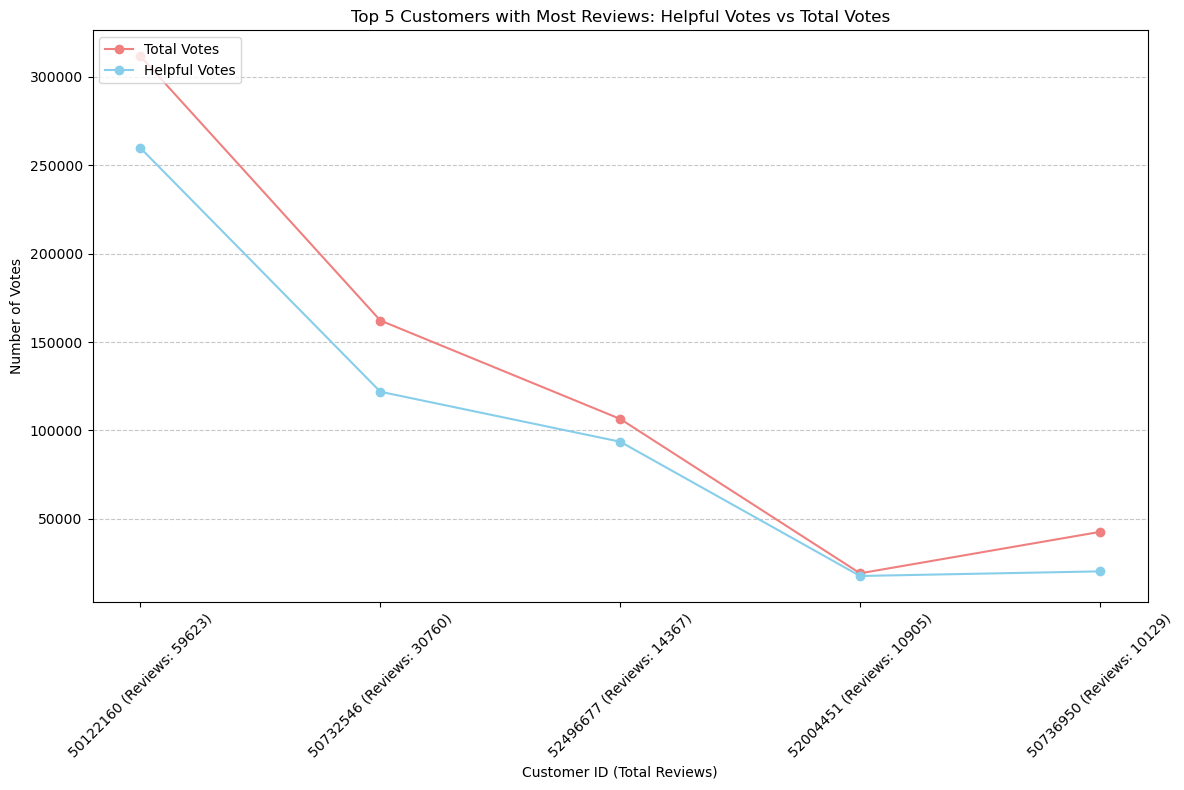

In [ ]:
import matplotlib.pyplot as plt

top_5_customers = customer_review_summary.orderBy("total_reviews", ascending=False).limit(5).toPandas()

x_labels = [f"{row['customer_id']} (Reviews: {row['total_reviews']})" for _, row in top_5_customers.iterrows()]

plt.figure(figsize=(12, 8))

plt.plot(x_labels, top_5_customers["total_votes_sum"], marker='o', color='lightcoral', label="Total Votes")
plt.plot(x_labels, top_5_customers["helpful_votes_sum"], marker='o', color='skyblue', label="Helpful Votes")

plt.title("Top 5 Customers with Most Reviews: Helpful Votes vs Total Votes")
plt.xlabel("Customer ID (Total Reviews)")
plt.ylabel("Number of Votes")
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()


The analysis indicates that there is a positive correlation between the number of reviews a customer publishes and the engagement they receive, as measured by helpful votes. Customers who publish more reviews are generally more visible, attract more engagement, and are often viewed as helpful contributors to the platform. 